In [2]:
import os
import pandas as pd #Import pandas for operations
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay


In [3]:
#0. Import data
dataframe = pd.read_csv('data/sdss_100k_galaxy_form_burst.csv', low_memory=False, header=1)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [4]:
# 0.1. Data Statistical Analysis
print(f"Dataset shape: {dataframe.shape}")

numerical_features = dataframe.select_dtypes(include='number').columns
z_scores = dataframe[numerical_features].apply(zscore)  # compute z-score for each numeric column
threshold = 3 #How many STD. we consider outlier.
outliers_z = (abs(z_scores) > threshold)

print(dataframe[outliers_z.any(axis=1)])  # rows containing at least one outlier
# Data is somewhat skewed


Dataset shape: (100000, 43)
                     objid            specobjid          ra        dec  \
4      1237648702973149350   332154249716721664  198.706864  -1.046217   
42     1237648721763238209   314301479399745536  170.073523   0.405995   
54     1237651192432165212  8192142948407990272  131.241240  53.208364   
58     1237651251482067624  7181230230211942400  122.631878  45.281591   
72     1237648704061309661  4517153671457560576  231.533375  -0.340179   
...                    ...                  ...         ...        ...   
99928  1237662236392685639  1384880019989358592  184.933948   9.148592   
99936  1237662236929622034  1384887441692846080  185.110612   9.424278   
99957  1237654381978845196   623782117049919488  140.589226  53.606884   
99968  1237664667902214147  2354413718323881984  165.917906  37.929384   
99977  1237664669494804798  1783437871319902208  121.816368  21.689839   

                u           g         r         i         z  modelFlux_u  ...  \
4 

In [5]:
# 1 Data pre-processing

# 1.1.0 Smoothen out outliers by means of Robust Scaler
robust_scaler = RobustScaler() # Initialize scaler
robust_scaled_values = robust_scaler.fit_transform(dataframe[numerical_features]) # Scale only numerical data from dataset.
robust_scaled_df = pd.DataFrame(robust_scaled_values, columns=numerical_features, index=dataframe.index) # Convert scaled data to pandas dataframe NB: index so it aligns with OG.
scaled_dataframe = dataframe.copy() # Create a copy of Dataframe to preserve original.
scaled_dataframe[numerical_features] = robust_scaled_df # Copy scaled values over into new copy.

# 1.1.1 remove unnecessary columns
modified_dataframe = scaled_dataframe.drop(['objid', 'specobjid', 'class'], axis=1)

In [6]:
# 3. Begin Training Model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#3.1. Setup Model with Params.
class galaxy_classification_nn(nn.Module):
    def __init__(self,  dropout_rate=0.4):

        # Store dropout rate.
        self.dropout_rate = dropout_rate

        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=39, out_features=133)
        self.hidden_layer2 = nn.Linear(in_features=133, out_features=133)
        self.output_layer = nn.Linear(in_features=133, out_features=2)

        # Specify activation functions.
        self.activation_function1 = nn.Tanh() # Input -> Hidden 1
        self.activation_function2 = nn.ReLU() # Hidden 1 -> Hidden 2

        # Added dropout layers.
        self.dropout_layer1 = nn.Dropout(p=self.dropout_rate) #Dropout H1 -> H2
        self.dropout_layer2 = nn.Dropout(p=self.dropout_rate) #Droput H2 -> Output


    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.activation_function1(x)
        x = self.dropout_layer1(x)

        x = self.hidden_layer2(x)
        x = self.activation_function2(x)
        x = self.dropout_layer2(x)

        x = self.output_layer(x)

        return x

    def get_weights(self, model_type):
        if model_type == 'traditional':
            init.xavier_normal_(self.input_layer.weight, )
            init.kaiming_normal(self.hidden_layer.weight)
            init.xavier_normal_(self.output_layer.weight)
            return
        elif model_type == 'sign_based':
            init.xavier_normal_(self.input_layer.weight)

In [7]:
def standardize_data(data, std_type):
    scaler = StandardScaler()
    data_scaled = None

    if std_type == 'fit':
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)

    return data_scaled

In [8]:
import torch.optim as optim

#3.2. Init. model
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

galaxy_classification_model = galaxy_classification_nn(dropout_rate=0.4).to(device)

#3.2. Setup Optimizer
loss_function = nn.CrossEntropyLoss()

# Sign-Based approach setup
error_optimizer = optim.Rprop(
    galaxy_classification_model.parameters(),
    lr=0.01,        # initial step size per weight
    etas=(0.5, 1.2),# (eta_minus, eta_plus)
    step_sizes=(1e-6, 50.0)  # (min_step, max_step)
)

#SGD Regular setup - Control
control_error_optimizer = optim.SGD(galaxy_classification_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Hyperparameter optimization: TODO: Move Below
# Variables: Initial learning rate and dropout rate
k_fold = StratifiedKFold(n_splits=2, shuffle=True)
learning_rates_list = [0.001, 0.01, 0.05, 0.1]
dropout_rates_list = [0.2, 0.4, 0.6, 0.8]
number_of_independent_runs = 2
results_list = []
hpo_epoch_count = 10

# 1. Get Dataset Labels & Features TODO: Remove when move down.

dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

for learning_rate in learning_rates_list:
    for dropout_rate in dropout_rates_list:
        print(f"Learning rate: {learning_rate}, Dropout rate: {dropout_rate}")
        fold_scores = []

        # Repeat individual runs
        for run in range(number_of_independent_runs):
            kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=run)

            for fold, (train_index, test_index) in enumerate(k_fold.split(dataset_features, dataset_labels), 1):
                print(f"\nCurrent Fold {fold}:")

                # 2. Split current folds into test and training set
                features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
                labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

                features_train_numpy = features_train.to_numpy()
                features_test_numpy = features_test.to_numpy()

                # 3. Normalize dataset
                standard_scaler = StandardScaler()
                features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
                features_test_scaled = standard_scaler.transform(features_test_numpy)

                # 4. Convert to Tensors
                features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
                features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
                labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
                labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

                # 5. Create Dataloaders
                training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
                testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

                training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
                testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

                # 6. Compute class weights to address class imbalance
                class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
                class_weights = torch.tensor(class_weights, dtype=torch.float32)


                #Setup current model.
                galaxy_classification_model_hpo = galaxy_classification_nn(dropout_rate=dropout_rate).to(device)
                loss_function_hpo = nn.CrossEntropyLoss()
                error_optimizer_hpo = optim.Rprop(
                    galaxy_classification_model_hpo.parameters(),
                    lr=learning_rate,  # initial step size per weight
                    etas=(0.5, 1.2),# (eta_minus, eta_plus)
                    step_sizes=(1e-6, 50.0)  # (min_step, max_step)
                )

                # train for N epochs
                for epoch in range(hpo_epoch_count):
                    galaxy_classification_model_hpo.train()
                    for feature_batch, label_batch in training_dataset_loader:
                        error_optimizer_hpo.zero_grad()
                        outputs_hpo = galaxy_classification_model_hpo(feature_batch)
                        loss_hpo = loss_function_hpo(outputs_hpo, label_batch)
                        loss_hpo.backward()
                        error_optimizer_hpo.step()

                # evaluate
                galaxy_classification_model_hpo.eval()
                preds_hpo, true_hpo = [], []
                with torch.no_grad():
                    for feature_batch, label_batch in testing_dataset_loader:
                        outputs_eval_hpo = galaxy_classification_model_hpo(feature_batch)
                        preds_hpo.extend(torch.argmax(outputs_eval_hpo, dim=1).cpu().numpy())
                        true_hpo.extend(label_batch.cpu().numpy())

                f1 = f1_score(true_hpo, preds_hpo, average="macro")
                fold_scores.append(f1)

            avg_f1 = np.mean(fold_scores)
            std_f1 = np.std(fold_scores)
            print(f"Avg F1 for lr={learning_rate}, dropout={dropout_rate}: {avg_f1:.3f}")
            results_list.append({"learning_rate": learning_rate, "dropout": dropout_rate, "f1": avg_f1, "std_f1": std_f1})

# 2. Convert results to dataframe for visualization.
results_df = pd.DataFrame(results_list)
pivot_table_mean = results_df.pivot(index="dropout", columns="learning_rate", values="f1")
pivot_table_std = results_df.pivot(index="dropout", columns="learning_rate", values="std_f1")
print(pivot_table_mean)

# 3. Plot Heatmap.
plt.figure(figsize=(8,6))
heatmap = plt.imshow(pivot_table_mean, cmap="plasma", aspect="auto", origin="lower")

plt.colorbar(heatmap, label="Average F1-score")
plt.xticks(range(len(pivot_table_mean.columns)), pivot_table_mean.columns)
plt.yticks(range(len(pivot_table_mean.index)), pivot_table_mean.index)

plt.xlabel("Learning Rate")
plt.ylabel("Dropout Rate")
plt.title("Grid Search F1 Heatmap")

for i in range(pivot_table_mean.shape[0]):  # rows (dropout)
    for j in range(pivot_table_mean.shape[1]):  # cols (learning rate)
        mean_value = pivot_table_mean.iloc[i, j]
        std_value = pivot_table_std.iloc[i, j]
        plt.text(j, i, f"{mean_value:.3f} : {std_value:.3f}", ha="center", va="center", color="white")

plt.show()



Starting Sign-Based model training:


Current Fold 1:
Fold scores for current sign fold 1 of run 0:

Fold Accuracy Scores: [0.8492]

Fold F1 Scores: [0.7767010860915635]

Fold 1 Accuracy: 0.849, F1: 0.777
  Class 0 -> Precision: 0.865, Recall: 0.946
  Class 1 -> Precision: 0.776, Recall: 0.559
Fold 1 Accuracy: 0.849, F1: 0.777
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_1_run_0.pt with accuracy 0.777


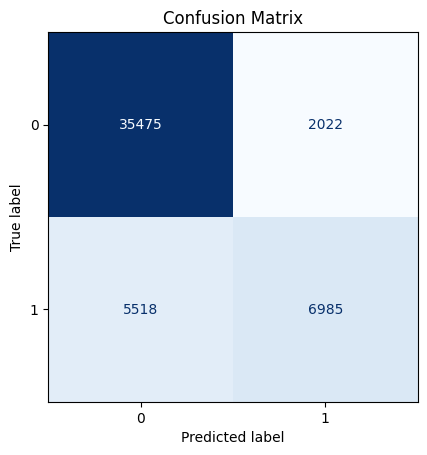


Current Fold 2:
Fold scores for current sign fold 2 of run 0:

Fold Accuracy Scores: [0.84806]

Fold F1 Scores: [0.77284817269517]

Fold 2 Accuracy: 0.848, F1: 0.773
  Class 0 -> Precision: 0.862, Recall: 0.949
  Class 1 -> Precision: 0.781, Recall: 0.545
Fold 2 Accuracy: 0.848, F1: 0.773


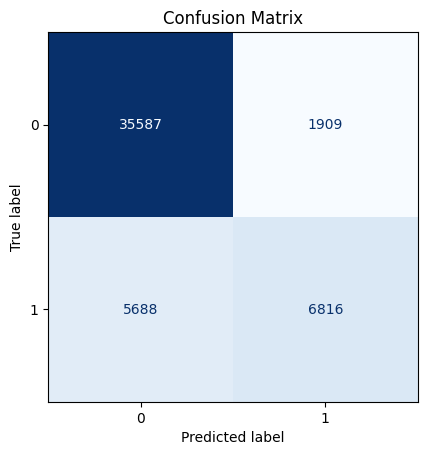


At fold 2 of run 0:


Overall Accuracy Scores for run 0: [np.float64(0.84806)]
Overall F1 Scores for run 0: [np.float64(0.77284817269517)]

=== Final Results for current run ===
Average Accuracy: 0.84806
Average F1-score: 0.77284817269517

Current Fold 1:
Fold scores for current sign fold 1 of run 1:

Fold Accuracy Scores: [0.82454]

Fold F1 Scores: [0.7236704733662247]

Fold 1 Accuracy: 0.825, F1: 0.724
  Class 0 -> Precision: 0.836, Recall: 0.953
  Class 1 -> Precision: 0.756, Recall: 0.441
Fold 1 Accuracy: 0.825, F1: 0.724


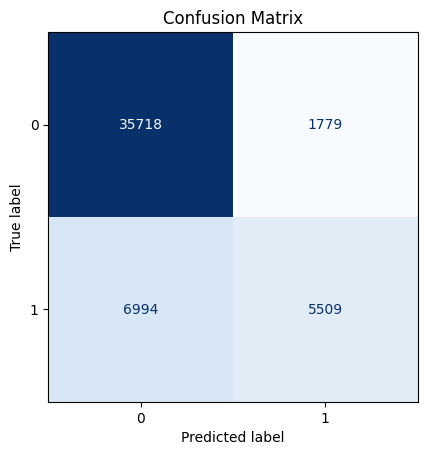


Current Fold 2:
Fold scores for current sign fold 2 of run 1:

Fold Accuracy Scores: [0.84892]

Fold F1 Scores: [0.7749301607752579]

Fold 2 Accuracy: 0.849, F1: 0.775
  Class 0 -> Precision: 0.864, Recall: 0.948
  Class 1 -> Precision: 0.780, Recall: 0.551
Fold 2 Accuracy: 0.849, F1: 0.775


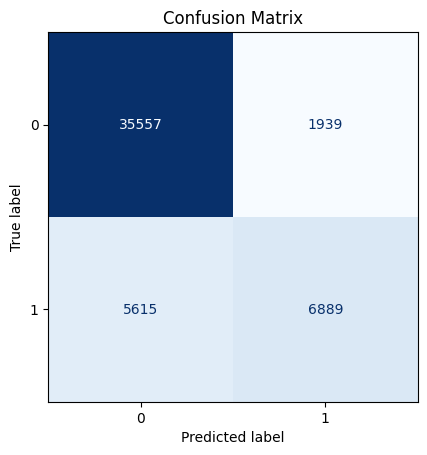


At fold 2 of run 1:


Overall Accuracy Scores for run 1: [np.float64(0.84806), np.float64(0.84892)]
Overall F1 Scores for run 1: [np.float64(0.77284817269517), np.float64(0.7749301607752579)]

=== Final Results for current run ===
Average Accuracy: 0.84849
Average F1-score: 0.7738891667352139

Current Fold 1:
Fold scores for current sign fold 1 of run 2:

Fold Accuracy Scores: [0.84038]

Fold F1 Scores: [0.7570480585016294]

Fold 1 Accuracy: 0.840, F1: 0.757
  Class 0 -> Precision: 0.853, Recall: 0.951
  Class 1 -> Precision: 0.775, Recall: 0.509
Fold 1 Accuracy: 0.840, F1: 0.757


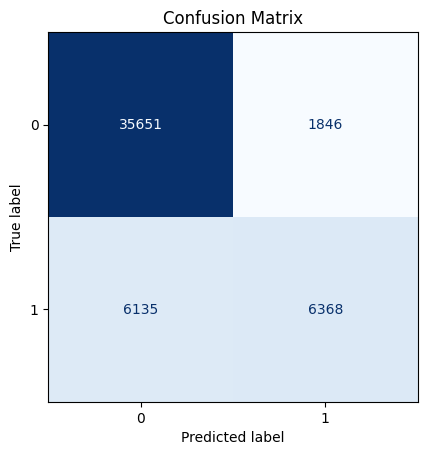


Current Fold 2:
Fold scores for current sign fold 2 of run 2:

Fold Accuracy Scores: [0.83318]

Fold F1 Scores: [0.7413063922732692]

Fold 2 Accuracy: 0.833, F1: 0.741
  Class 0 -> Precision: 0.845, Recall: 0.953
  Class 1 -> Precision: 0.770, Recall: 0.474
Fold 2 Accuracy: 0.833, F1: 0.741


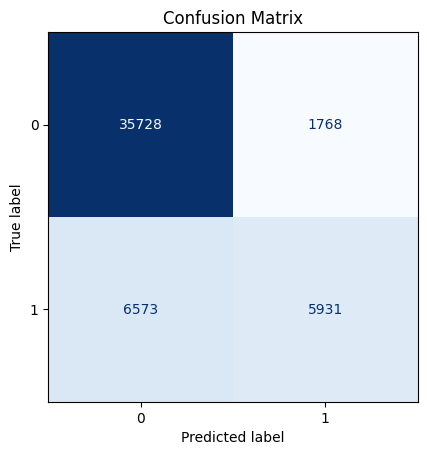


At fold 2 of run 2:


Overall Accuracy Scores for run 2: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318)]
Overall F1 Scores for run 2: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692)]

=== Final Results for current run ===
Average Accuracy: 0.8433866666666666
Average F1-score: 0.7630282419145656

Current Fold 1:
Fold scores for current sign fold 1 of run 3:

Fold Accuracy Scores: [0.82932]

Fold F1 Scores: [0.7387852596557529]

Fold 1 Accuracy: 0.829, F1: 0.739
  Class 0 -> Precision: 0.845, Recall: 0.945
  Class 1 -> Precision: 0.746, Recall: 0.481
Fold 1 Accuracy: 0.829, F1: 0.739


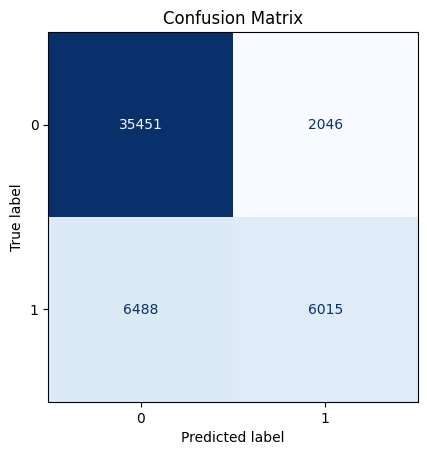


Current Fold 2:
Fold scores for current sign fold 2 of run 3:

Fold Accuracy Scores: [0.85356]

Fold F1 Scores: [0.781812731248706]

Fold 2 Accuracy: 0.854, F1: 0.782
  Class 0 -> Precision: 0.866, Recall: 0.951
  Class 1 -> Precision: 0.794, Recall: 0.560
Fold 2 Accuracy: 0.854, F1: 0.782
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_2_run_3.pt with accuracy 0.782


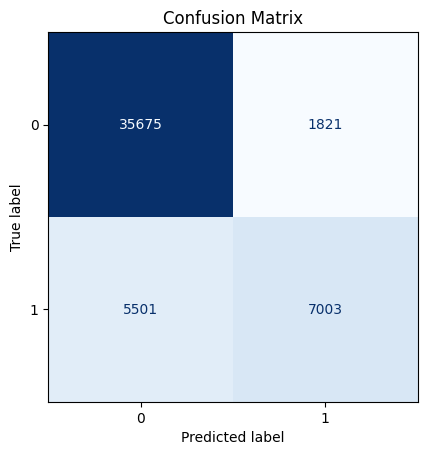


At fold 2 of run 3:


Overall Accuracy Scores for run 3: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356)]
Overall F1 Scores for run 3: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706)]

=== Final Results for current run ===
Average Accuracy: 0.84593
Average F1-score: 0.7677243642481008

Current Fold 1:
Fold scores for current sign fold 1 of run 4:

Fold Accuracy Scores: [0.8576]

Fold F1 Scores: [0.78886853423408]

Fold 1 Accuracy: 0.858, F1: 0.789
  Class 0 -> Precision: 0.870, Recall: 0.952
  Class 1 -> Precision: 0.800, Recall: 0.574
Fold 1 Accuracy: 0.858, F1: 0.789
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_1_run_4.pt with accuracy 0.789


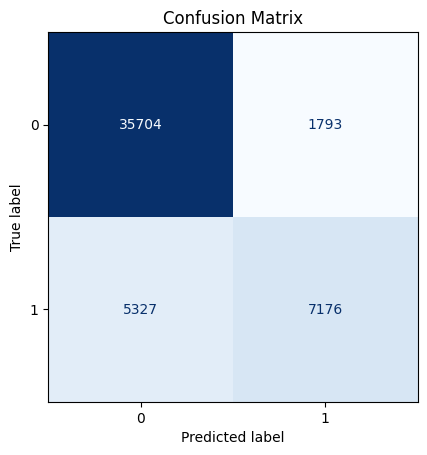


Current Fold 2:
Fold scores for current sign fold 2 of run 4:

Fold Accuracy Scores: [0.85184]

Fold F1 Scores: [0.7826540951072585]

Fold 2 Accuracy: 0.852, F1: 0.783
  Class 0 -> Precision: 0.870, Recall: 0.944
  Class 1 -> Precision: 0.774, Recall: 0.575
Fold 2 Accuracy: 0.852, F1: 0.783


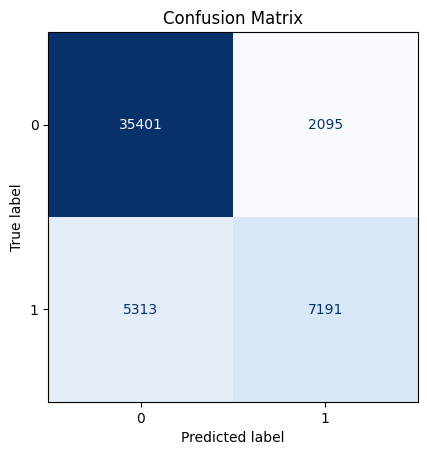


At fold 2 of run 4:


Overall Accuracy Scores for run 4: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356), np.float64(0.85184)]
Overall F1 Scores for run 4: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706), np.float64(0.7826540951072585)]

=== Final Results for current run ===
Average Accuracy: 0.8471119999999999
Average F1-score: 0.7707103104199323

Current Fold 1:
Fold scores for current sign fold 1 of run 5:

Fold Accuracy Scores: [0.84872]

Fold F1 Scores: [0.7791274434207615]

Fold 1 Accuracy: 0.849, F1: 0.779
  Class 0 -> Precision: 0.869, Recall: 0.940
  Class 1 -> Precision: 0.762, Recall: 0.575
Fold 1 Accuracy: 0.849, F1: 0.779


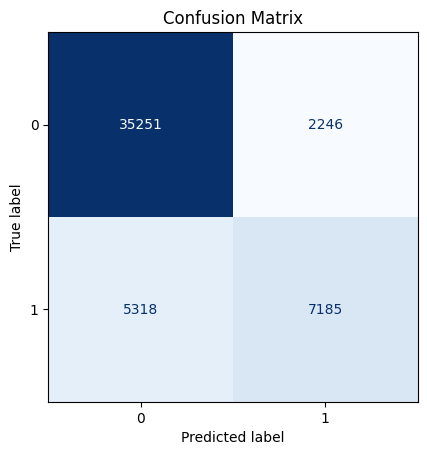


Current Fold 2:
Fold scores for current sign fold 2 of run 5:

Fold Accuracy Scores: [0.8644]

Fold F1 Scores: [0.8024733349723424]

Fold 2 Accuracy: 0.864, F1: 0.802
  Class 0 -> Precision: 0.879, Recall: 0.950
  Class 1 -> Precision: 0.801, Recall: 0.609
Fold 2 Accuracy: 0.864, F1: 0.802
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_2_run_5.pt with accuracy 0.802


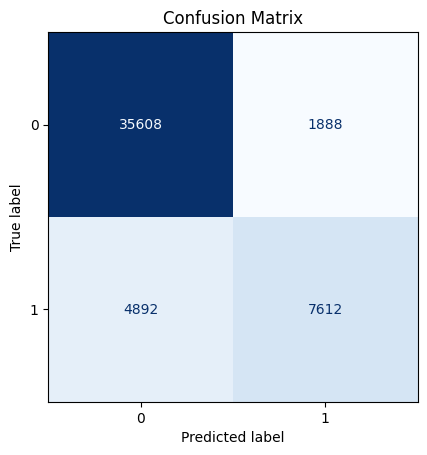


At fold 2 of run 5:


Overall Accuracy Scores for run 5: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356), np.float64(0.85184), np.float64(0.8644)]
Overall F1 Scores for run 5: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706), np.float64(0.7826540951072585), np.float64(0.8024733349723424)]

=== Final Results for current run ===
Average Accuracy: 0.8499933333333333
Average F1-score: 0.776004147845334

Current Fold 1:
Fold scores for current sign fold 1 of run 6:

Fold Accuracy Scores: [0.8447]

Fold F1 Scores: [0.7682074705062394]

Fold 1 Accuracy: 0.845, F1: 0.768
  Class 0 -> Precision: 0.861, Recall: 0.946
  Class 1 -> Precision: 0.770, Recall: 0.540
Fold 1 Accuracy: 0.845, F1: 0.768


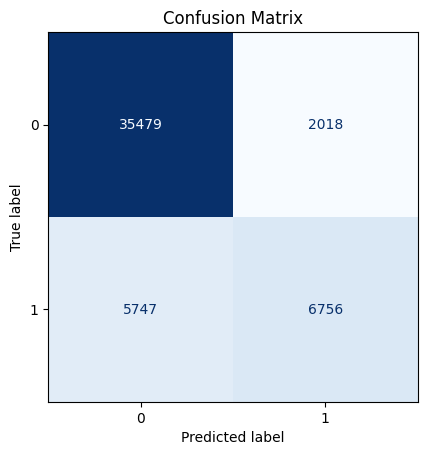


Current Fold 2:
Fold scores for current sign fold 2 of run 6:

Fold Accuracy Scores: [0.8553]

Fold F1 Scores: [0.7851017849816428]

Fold 2 Accuracy: 0.855, F1: 0.785
  Class 0 -> Precision: 0.868, Recall: 0.951
  Class 1 -> Precision: 0.795, Recall: 0.567
Fold 2 Accuracy: 0.855, F1: 0.785


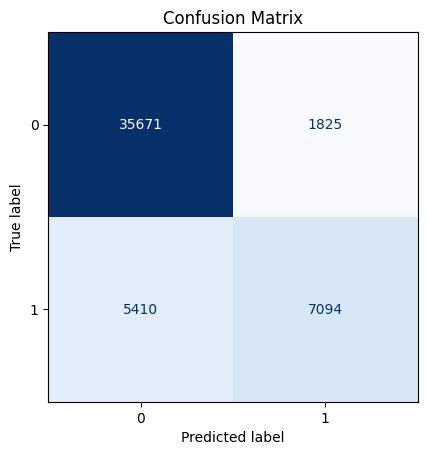


At fold 2 of run 6:


Overall Accuracy Scores for run 6: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356), np.float64(0.85184), np.float64(0.8644), np.float64(0.8553)]
Overall F1 Scores for run 6: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706), np.float64(0.7826540951072585), np.float64(0.8024733349723424), np.float64(0.7851017849816428)]

=== Final Results for current run ===
Average Accuracy: 0.8507514285714285
Average F1-score: 0.7773038102933781

Current Fold 1:
Fold scores for current sign fold 1 of run 7:

Fold Accuracy Scores: [0.8537]

Fold F1 Scores: [0.7798204965573525]

Fold 1 Accuracy: 0.854, F1: 0.780
  Class 0 -> Precision: 0.864, Recall: 0.955
  Class 1 -> Precision: 0.804, Recall: 0.549
Fold 1 Accuracy: 0.854, F1: 0.780


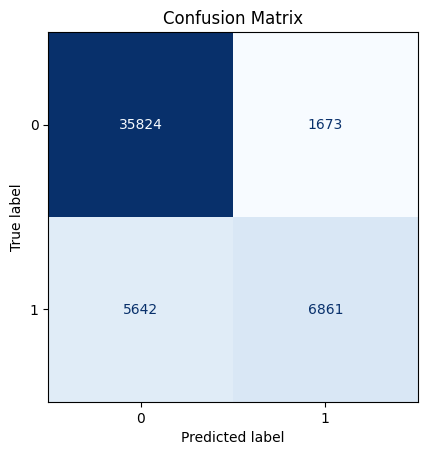


Current Fold 2:
Fold scores for current sign fold 2 of run 7:

Fold Accuracy Scores: [0.82938]

Fold F1 Scores: [0.7367919242665428]

Fold 2 Accuracy: 0.829, F1: 0.737
  Class 0 -> Precision: 0.844, Recall: 0.948
  Class 1 -> Precision: 0.753, Recall: 0.472
Fold 2 Accuracy: 0.829, F1: 0.737


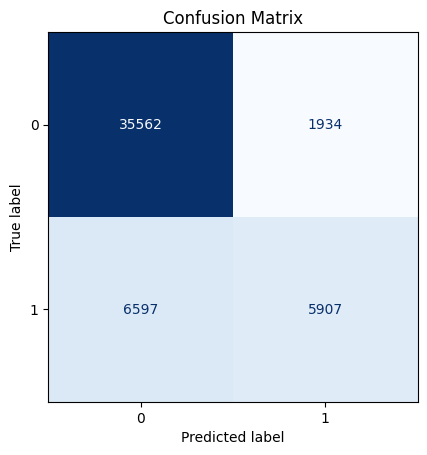


At fold 2 of run 7:


Overall Accuracy Scores for run 7: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356), np.float64(0.85184), np.float64(0.8644), np.float64(0.8553), np.float64(0.82938)]
Overall F1 Scores for run 7: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706), np.float64(0.7826540951072585), np.float64(0.8024733349723424), np.float64(0.7851017849816428), np.float64(0.7367919242665428)]

=== Final Results for current run ===
Average Accuracy: 0.84808
Average F1-score: 0.7722398245400237

Current Fold 1:
Fold scores for current sign fold 1 of run 8:

Fold Accuracy Scores: [0.84082]

Fold F1 Scores: [0.7601852640336831]

Fold 1 Accuracy: 0.841, F1: 0.760
  Class 0 -> Precision: 0.856, Recall: 0.947
  Class 1 -> Precision: 0.767, Recall: 0.522
Fold 1 Accuracy: 0.841, F1: 0.760


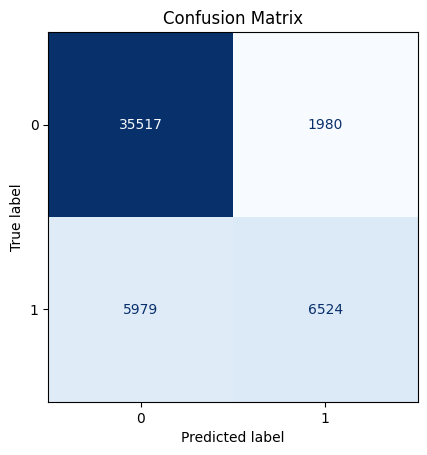


Current Fold 2:
Fold scores for current sign fold 2 of run 8:

Fold Accuracy Scores: [0.8435]

Fold F1 Scores: [0.7585742360081699]

Fold 2 Accuracy: 0.844, F1: 0.759
  Class 0 -> Precision: 0.852, Recall: 0.958
  Class 1 -> Precision: 0.798, Recall: 0.501
Fold 2 Accuracy: 0.844, F1: 0.759


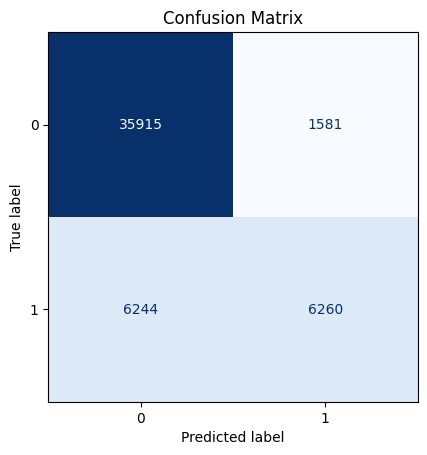


At fold 2 of run 8:


Overall Accuracy Scores for run 8: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356), np.float64(0.85184), np.float64(0.8644), np.float64(0.8553), np.float64(0.82938), np.float64(0.8435)]
Overall F1 Scores for run 8: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706), np.float64(0.7826540951072585), np.float64(0.8024733349723424), np.float64(0.7851017849816428), np.float64(0.7367919242665428), np.float64(0.7585742360081699)]

=== Final Results for current run ===
Average Accuracy: 0.847571111111111
Average F1-score: 0.7707214258142622

Current Fold 1:
Fold scores for current sign fold 1 of run 9:

Fold Accuracy Scores: [0.8374]

Fold F1 Scores: [0.7566684225648884]

Fold 1 Accuracy: 0.837, F1: 0.757
  Class 0 -> Precision: 0.856, Recall: 0.942
  Class 1 -> Precision: 0.751, Recall: 0.523
Fold 1 Accuracy: 0.837, F1: 0.757


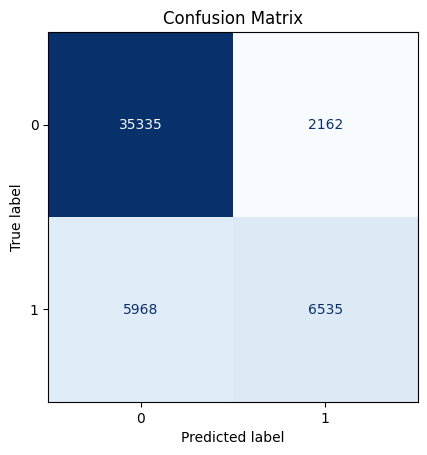


Current Fold 2:
Fold scores for current sign fold 2 of run 9:

Fold Accuracy Scores: [0.8608]

Fold F1 Scores: [0.795676325032691]

Fold 2 Accuracy: 0.861, F1: 0.796
  Class 0 -> Precision: 0.875, Recall: 0.950
  Class 1 -> Precision: 0.799, Recall: 0.592
Fold 2 Accuracy: 0.861, F1: 0.796


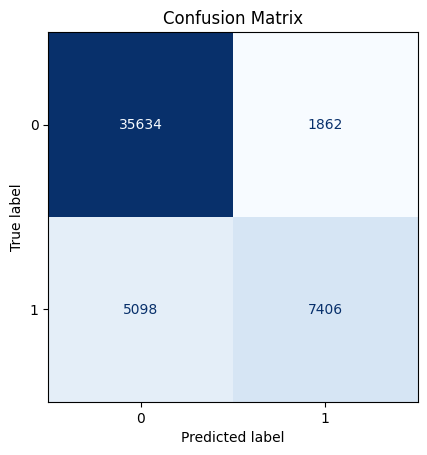


At fold 2 of run 9:


Overall Accuracy Scores for run 9: [np.float64(0.84806), np.float64(0.84892), np.float64(0.83318), np.float64(0.85356), np.float64(0.85184), np.float64(0.8644), np.float64(0.8553), np.float64(0.82938), np.float64(0.8435), np.float64(0.8608)]
Overall F1 Scores for run 9: [np.float64(0.77284817269517), np.float64(0.7749301607752579), np.float64(0.7413063922732692), np.float64(0.781812731248706), np.float64(0.7826540951072585), np.float64(0.8024733349723424), np.float64(0.7851017849816428), np.float64(0.7367919242665428), np.float64(0.7585742360081699), np.float64(0.795676325032691)]

=== Final Results for current run ===
Average Accuracy: 0.8488939999999999
Average F1-score: 0.7732169157361051


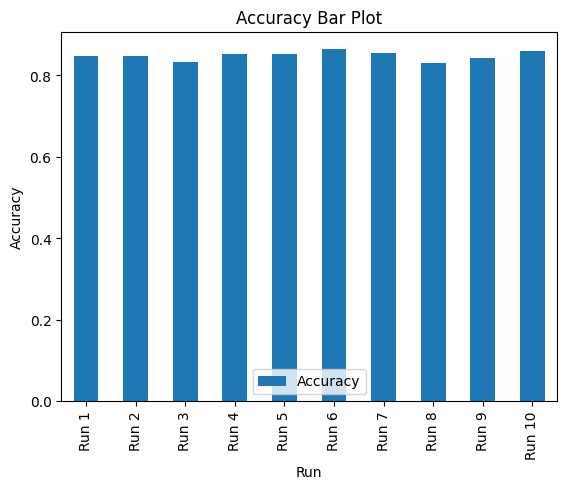

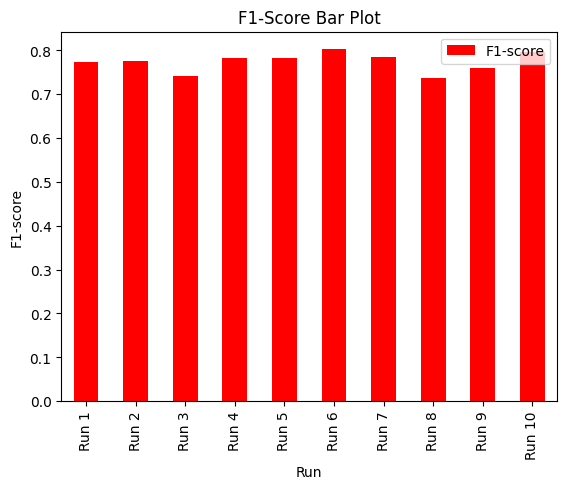

In [14]:
# Sign-Based Training.

accuracy_score_list = [] #For all independent runs
f1_score_list = [] #For all independent runs
epoch_count = 2
number_of_independent_runs_sign_based = 10
results_list_sign_based = []
save_dir = "saved_classifiers"
os.makedirs(save_dir, exist_ok=True)
fold_count = 2

current_best_performing_model = 0.0
overall_f1_list = []
overall_acc_list = []

# 1. Get Dataset Labels & Features
dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

print("\nStarting Sign-Based model training:\n")

for run in range(number_of_independent_runs_sign_based):
    k_fold_sign_based = StratifiedKFold(n_splits=fold_count, shuffle=True)


    for fold, (train_index, test_index) in enumerate(k_fold_sign_based.split(dataset_features, dataset_labels), 1):
        print(f"\nCurrent Fold {fold}:")
        current_sign_fold_f1_scores = []
        current_sign_fold_acc_scores = []

        # 2. Split current folds into test and training set
        features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
        labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

        features_train_numpy = features_train.to_numpy()
        features_test_numpy = features_test.to_numpy()

        # 3. Normalize dataset
        standard_scaler = StandardScaler()
        features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
        features_test_scaled = standard_scaler.transform(features_test_numpy)

        # 4. Convert to Tensors
        features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
        features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
        labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
        labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

        # 5. Create Dataloaders
        training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
        testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

        training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
        testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

        # 6. Compute class weights to address class imbalance
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
        class_weights = torch.tensor(class_weights, dtype=torch.float32)

        # 7. Redefine model in training loop.
        galaxy_classification_model = galaxy_classification_nn(dropout_rate=0.2).to(device)
        loss_function = nn.CrossEntropyLoss()
        error_optimizer = optim.Rprop(
            galaxy_classification_model.parameters(),
            lr=0.001,        # initial step size per weight
            etas=(0.5, 1.2),# (eta_minus, eta_plus)
            step_sizes=(1e-6, 50.0)  # (min_step, max_step)
        )

        # 8. Begin training loop for fold
        galaxy_classification_model.train()
        for epoch in range(epoch_count):
            for features, labels in training_dataset_loader:
                error_optimizer.zero_grad()
                outputs = galaxy_classification_model(features)
                loss = loss_function(outputs, labels)
                loss.backward()
                error_optimizer.step()

        # 9. Evaluation loop
        galaxy_classification_model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for features, labels in testing_dataset_loader:
                outputs = galaxy_classification_model(features)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())


        # Compute metrics

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="macro")
        current_sign_fold_f1_scores.append(f1)
        current_sign_fold_acc_scores.append(acc)

        print(f"Fold scores for current sign fold {fold} of run {run}:\n")
        print(f"Fold Accuracy Scores: {current_sign_fold_acc_scores}\n")
        print(f"Fold F1 Scores: {current_sign_fold_f1_scores}\n")

        accuracy_score_list.append(acc)
        f1_score_list.append(f1)

        # Per-class precision and recall
        precision_per_class = precision_score(all_labels, all_preds, average=None)
        recall_per_class    = recall_score(all_labels, all_preds, average=None)

        print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")
        for cls_idx, (prec, rec) in enumerate(zip(precision_per_class, recall_per_class)):
            print(f"  Class {cls_idx} -> Precision: {prec:.3f}, Recall: {rec:.3f}")

        print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")

        # Evaluate if current model is best and save
        if f1 > current_best_performing_model:
            current_best_performing_model = f1
            file_save_path = os.path.join(save_dir, f"f1_score_{fold}.pt")
            torch.save(galaxy_classification_model.state_dict(), file_save_path)
            print(f"Save current best performing model to {file_save_path} with accuracy {f1:.3f}")

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()

        if fold >= fold_count:
            print(f"\nAt fold {fold} of run {run}:\n")
            overall_acc_list.append(np.mean(current_sign_fold_acc_scores))
            overall_f1_list.append(np.mean(current_sign_fold_f1_scores))
            print(f"\nOverall Accuracy Scores for run {run}: {overall_acc_list}")
            print(f"Overall F1 Scores for run {run}: {overall_f1_list}")


    # Average results across folds
    print("\n=== Final Results for current run ===")
    print("Average Accuracy:", np.mean(overall_acc_list))
    print("Average F1-score:", np.mean(overall_f1_list))

sign_acc_table = pd.DataFrame(overall_acc_list, columns=["Accuracy"])
sign_f1_table = pd.DataFrame(overall_f1_list, columns=["F1-Score"])
sign_plot_labels = [f"Run {i+1}" for i in range(len(overall_acc_list))]

sign_acc_table.plot(x='Accuracy', y='Value', kind='bar', title='Accuracy Bar Plot')
plt.ylabel('Value')
plt.show()

